### Load modules; import and begin to process data

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import random

urls = []
for u in np.arange(16,24,1):
    urls.append(f'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_20{u}.csv')

df = pd.concat([pd.read_csv(url) for url in urls])
df.columns = [re.sub("^w_", "winner_", re.sub("^l_", "loser_", df.columns[c])) for c in np.arange(len(df.columns))]

# encode counties as binary
countries_encoded = pd.get_dummies(df[['winner_ioc', 'loser_ioc']])
metadata = df[list(filter(re.compile('.*name').match, df.columns))]

#create unique match ID
df['match_id'] = df['tourney_id'].astype(str) + df['match_num'].astype(str)

df = df[df.tourney_level != 'D'] # exclude Davis Cup
df.sort_values(by=['tourney_date', 'tourney_id', 'match_num'], inplace=True)
df.groupby(['winner_id']).cumcount().add(1).reset_index().drop('index', axis = 1)
df = df.reset_index().drop('index', axis = 1)

df['match_number_absolute'] = [i for i in np.arange(len(df))]

df['p0_id'] = df[['winner_id']]
df['p1_id'] = df[['loser_id']]

### Encode categorical variables as binary features (one per catergory)

In [2]:
dummies = pd.DataFrame()

# encode winner and loser ID, handedness, and surface type
for v,f in zip([df.winner_id, df.loser_id, df.loser_hand, df.winner_hand, df.surface], ['winner_id', 'loser_id', 'loser_hand', 'winner_hand', 'surface']):
    dummies = pd.concat([dummies, pd.get_dummies(v, prefix=f).astype(int)], axis = 1)

# add to df
df_with_dummies = pd.concat([
    df,
    dummies,
    pd.DataFrame({'winner_id_' + str(l): [0 for i in np.arange(len(df))] for l in df.loser_id.unique() if l not in df.winner_id.unique()}),
    pd.DataFrame({'loser_id_' + str(w): [0 for i in np.arange(len(df))] for w in df.winner_id.unique() if w not in df.loser_id.unique()})
    ], axis = 1)

df_with_dummies

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,winner_id_209405,winner_id_212021,winner_id_126533,winner_id_208659,winner_id_207785,winner_id_209259,winner_id_202261,winner_id_208118,winner_id_208300,winner_id_109734
0,2016-0451,Doha,Hard,32,A,20160104,270,104745,2.0,NaN,...,0,0,0,0,0,0,0,0,0,0
1,2016-0451,Doha,Hard,32,A,20160104,271,104898,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,2016-0451,Doha,Hard,32,A,20160104,272,105723,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,2016-0451,Doha,Hard,32,A,20160104,273,105575,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,2016-0451,Doha,Hard,32,A,20160104,274,105011,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19293,2023-7480,Los Cabos,Hard,32,A,20230731,296,106432,4,NaN,...,0,0,0,0,0,0,0,0,0,0
19294,2023-7480,Los Cabos,Hard,32,A,20230731,297,126774,1,NaN,...,0,0,0,0,0,0,0,0,0,0
19295,2023-7480,Los Cabos,Hard,32,A,20230731,298,200282,5,NaN,...,0,0,0,0,0,0,0,0,0,0
19296,2023-7480,Los Cabos,Hard,32,A,20230731,299,126774,1,NaN,...,0,0,0,0,0,0,0,0,0,0


### Include potential features only

In [3]:
# Include features by searching colummn names
matchplay_stats =  df_with_dummies.filter(regex = r'winner_|loser_|grass|clay|hard|p._id|match_number_absolute', axis = 1)

# Exclude some features by searching colummn names
matchplay_stats = matchplay_stats.filter(regex = r'^(?!.*(?:seed$|entry$|name$|ioc$|hand$|winner_id$|loser_id$))', axis = 1)

# randomly assign which player the winner will be
matchplay_stats['winner-position'] = [random.randint(0,1) for r in np.arange(len(matchplay_stats))]

# move player 1 losers to the winners columns and rename them to reflect player 1, vice versa for player 2 winners
losers = matchplay_stats[matchplay_stats['winner-position'] == 1]
winners = matchplay_stats[matchplay_stats['winner-position'] == 0]

# Rename the columns for plauyers 1 and 2 rather than winners and losers, then combine
losers.columns = [re.sub('winner_', 'p1_', re.sub('loser_', 'p0_', losers.columns[i])) for i in np.arange(len(losers.columns))]
winners.columns = [re.sub('winner_', 'p0_', re.sub('loser_', 'p1_', winners.columns[i])) for i in np.arange(len(winners.columns))]

matchplay_stats = pd.concat([losers, winners], axis = 0)

# feature_indices = np.arange(len(matchplay_stats.columns))

# features_dict = {f: matchplay_stats.columns[f] for f in feature_indices}

# matchplay_stats.columns = [f for f in feature_indices]

# print(features_dict)
matchplay_stats

,p1_ht,p1_age,p0_ht,p0_age,p1_ace,p1_df,p1_svpt,p1_1stIn,p1_1stWon,p1_2ndWon,...,p1_id_212021,p1_id_126533,p1_id_208659,p1_id_207785,p1_id_209259,p1_id_202261,p1_id_208118,p1_id_208300,p1_id_109734,winner-position
0,185.0,29.5,188.0,24.4,5.0,1.0,80.0,59.0,44.0,13.0,...,0,0,0,0,0,0,0,0,0,1
2,185.0,24.8,190.0,28.5,7.0,2.0,55.0,29.0,25.0,13.0,...,0,0,0,0,0,0,0,0,0,1
3,175.0,25.5,190.0,31.8,2.0,1.0,78.0,50.0,31.0,13.0,...,0,0,0,0,0,0,0,0,0,1
4,185.0,28.3,175.0,33.7,4.0,4.0,102.0,61.0,47.0,22.0,...,0,0,0,0,0,0,0,0,0,1
5,188.0,30.6,183.0,30.2,2.0,3.0,77.0,48.0,36.0,17.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19291,NaN,24.9,180.0,29.2,8.0,4.0,71.0,34.0,22.0,16.0,...,0,0,0,0,0,0,0,0,0,0
19292,185.0,26.2,183.0,24.4,4.0,3.0,80.0,45.0,35.0,14.0,...,0,0,0,0,0,0,0,0,0,0
19293,193.0,29.4,188.0,26.7,1.0,4.0,55.0,29.0,22.0,11.0,...,0,0,0,0,0,0,0,0,0,0
19296,188.0,26.7,193.0,24.9,1.0,5.0,42.0,27.0,17.0,5.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
all_player_matches = (
    pd.concat([
        matchplay_stats[['p0_id', 'match_number_absolute']].rename(columns={'p0_id': 'player_id'}),
        matchplay_stats[['p1_id', 'match_number_absolute']].rename(columns={'p1_id': 'player_id'})
    ], axis=0)
    .sort_values(['player_id', 'match_number_absolute'])
    .groupby('player_id')
    .apply(lambda df: df.assign(previous_match_number=df['match_number_absolute'].shift(1)))
    .reset_index(drop=True)
)

matchplay_stats_previous = (matchplay_stats.merge(
    all_player_matches, how='left', left_on=['p0_id','match_number_absolute'], right_on=['player_id','match_number_absolute'])
    .rename(columns={'previous_match_number':'p0_previous_match_number'}).drop(['player_id'], axis=1)
    .merge(
        all_player_matches, how='left', left_on=['p1_id','match_number_absolute'], right_on=['player_id','match_number_absolute'])
        .rename(columns={'previous_match_number':'p1_previous_match_number'})).drop(['player_id'], axis=1)

matchplay_stats_previous = (matchplay_stats_previous.merge(
    matchplay_stats, how='left', left_on=['p0_previous_match_number'], right_on=['match_number_absolute'], suffixes=('', '_previous_p0'))
    .rename(columns={'previous_match_number':'p0_previous_match_number'}))

matchplay_stats_previous = (matchplay_stats_previous.merge(
    matchplay_stats, how='left', left_on=['p1_previous_match_number'], right_on=['match_number_absolute'], suffixes=('', '_previous_p1'))
    .rename(columns={'previous_match_number':'p1_previous_match_number'})).reset_index(drop=True)

# matchplay_stats_x.columns
matchplay_stats_previous


,p1_ht,p1_age,p0_ht,p0_age,p1_ace,p1_df,p1_svpt,p1_1stIn,p1_1stWon,p1_2ndWon,...,p1_id_212021_previous_p1,p1_id_126533_previous_p1,p1_id_208659_previous_p1,p1_id_207785_previous_p1,p1_id_209259_previous_p1,p1_id_202261_previous_p1,p1_id_208118_previous_p1,p1_id_208300_previous_p1,p1_id_109734_previous_p1,winner-position_previous_p1
0,185.0,29.5,188.0,24.4,5.0,1.0,80.0,59.0,44.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,185.0,24.8,190.0,28.5,7.0,2.0,55.0,29.0,25.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,175.0,25.5,190.0,31.8,2.0,1.0,78.0,50.0,31.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,185.0,28.3,175.0,33.7,4.0,4.0,102.0,61.0,47.0,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,188.0,30.6,183.0,30.2,2.0,3.0,77.0,48.0,36.0,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19293,NaN,24.9,180.0,29.2,8.0,4.0,71.0,34.0,22.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19294,185.0,26.2,183.0,24.4,4.0,3.0,80.0,45.0,35.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19295,193.0,29.4,188.0,26.7,1.0,4.0,55.0,29.0,22.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19296,188.0,26.7,193.0,24.9,1.0,5.0,42.0,27.0,17.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
matchplay_stats_previous_only = pd.DataFrame(
    matchplay_stats_previous[[col for col in matchplay_stats_previous.columns if re.search('.*previous',col)]])

matchplay_stats_previous_only = matchplay_stats_previous_only[[col for col in matchplay_stats_previous_only.columns if not re.search('.*id.*',col)]]

matchplay_stats_previous_only.insert(0, 'winner-position', matchplay_stats_previous[['winner-position']])

matchplay_stats_previous_only = matchplay_stats_previous_only.dropna(subset='p0_previous_match_number')

matchplay_stats_previous_only = matchplay_stats_previous_only.dropna()

matchplay_stats_current_only = pd.DataFrame(
    matchplay_stats_previous[[col for col in matchplay_stats_previous.columns if not re.search('.*previous.*',col)]])

matchplay_stats_current_only_features = matchplay_stats_current_only[[col for col in matchplay_stats_current_only.columns if re.search('.*rank.*',col)]]
matchplay_stats_current_only_features.insert(0, 'winner-position', matchplay_stats_previous[['winner-position']])

matchplay_stats_current_only_features = matchplay_stats_current_only_features.dropna()


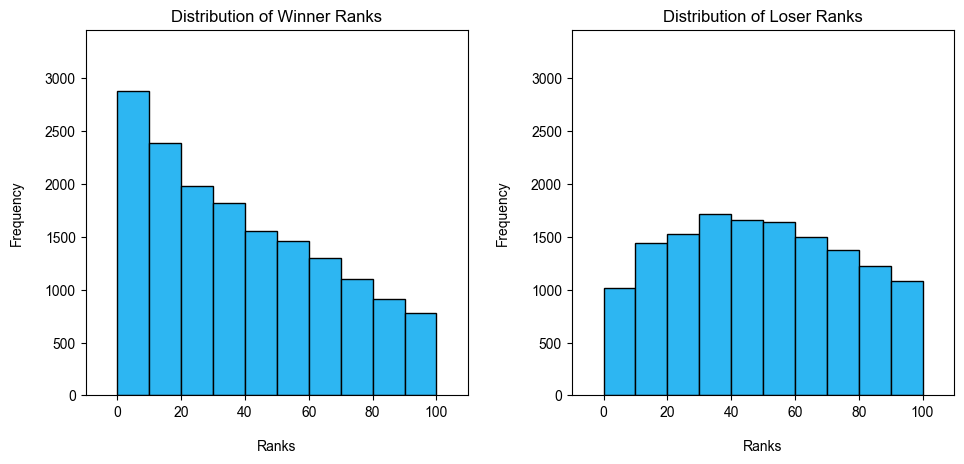

In [6]:
winner_ranks = np.concatenate([
    matchplay_stats_current_only_features.loc[matchplay_stats_current_only_features['winner-position'] == 1, 'p1_rank'],
    matchplay_stats_current_only_features.loc[matchplay_stats_current_only_features['winner-position'] == 0, 'p0_rank']
    ])


loser_ranks = np.concatenate([
    matchplay_stats_current_only_features.loc[matchplay_stats_current_only_features['winner-position'] == 1, 'p0_rank'],
    matchplay_stats_current_only_features.loc[matchplay_stats_current_only_features['winner-position'] == 0, 'p1_rank']
    ])

ranks_diff =  loser_ranks - winner_ranks

bins_win = np.arange(0, 1001, 10)  # Bin edges from 0 to 100 with a step of 10
hist_win, _ = np.histogram(winner_ranks, bins=bins_win)

bins_los = np.arange(0, 1001, 10)  # Bin edges from 0 to 100 with a step of 10
hist_los, _ = np.histogram(loser_ranks, bins=bins_los)

bins_diff = np.arange(-999, 1001, 10)  # Bin edges from 0 to 100 with a step of 10
hist_diff, _ = np.histogram(ranks_diff, bins=bins_diff)

# Create a figure with a specified size
fig, ax = plt.subplots(1,2,figsize=(10, 5))
with plt.style.context('seaborn-white'):
# Create a bar chart using the synthesized histogram data
    ax[0].bar(bins_win[:10], hist_win[:10], width=10, edgecolor='black', align='edge', color = '#2DB6F2')
    ax[0].set_title('Distribution of Winner Ranks')
    ax[0].set_xlabel('Ranks', labelpad=15)
    ax[0].set_ylabel('Frequency', labelpad=15)
    ax[0].set_xlim(-10, 110)
    ax[0].set_ylim(0, max(hist_win[:10]) * 1.20)

# Create a figure with a specified size
    ax[1].bar(bins_los[:10], hist_los[:10], width=10, edgecolor='black', align='edge', color = '#2DB6F2')
    ax[1].set_title('Distribution of Loser Ranks')
    ax[1].set_xlabel('Ranks', labelpad=15)
    ax[1].set_ylabel('Frequency', labelpad=15)
    ax[1].set_xlim(-10, 110)
    ax[1].set_ylim(0, max(hist_win[:10]) * 1.20)

    plt.tight_layout(pad=2)

    plt.show()
# matchplay_stats_current_only_features

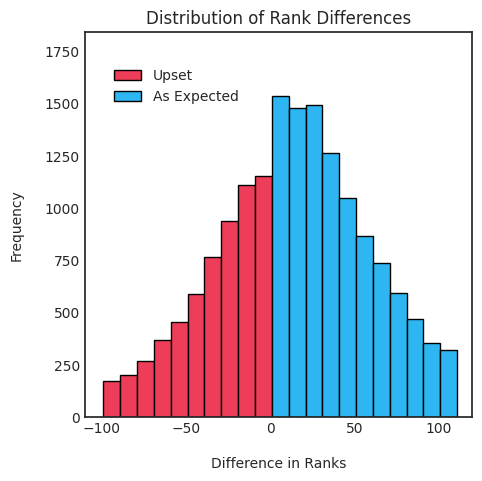

In [7]:
middle_bins = np.arange(len(bins_diff) / 2 - 10, len(bins_diff) / 2 + 11).astype(int)
colors = ['#EE3D58'] * 10 + ['#2DB6F2'] * 11
labels = ['Upset'] * 10 + ['As Expected'] * 11

# Apply the Seaborn style using plt.style.context()
with plt.style.context('seaborn-white'):
    fig, ax = plt.subplots(1,1,figsize=(5, 5))
    # Create a figure with a specified size
    ax.bar(bins_diff[middle_bins], hist_diff[middle_bins], width=10, edgecolor='black', align='edge', color = colors, label = labels)
    ax.set_title('Distribution of Rank Differences')
    ax.set_xlabel('Difference in Ranks', labelpad=15)
    ax.set_ylabel('Frequency', labelpad=15)
    ax.set_xlim(-110, 120)
    ax.set_ylim(0, max(hist_diff[middle_bins]) * 1.20)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc = [0.06,0.8])


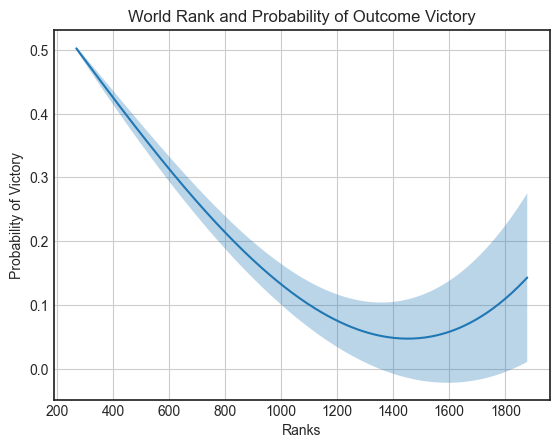

In [8]:
from scipy.interpolate import make_interp_spline

ranks = np.concatenate((loser_ranks, winner_ranks))
results = [0] * len(loser_ranks) + [1] * len(winner_ranks)

bins = np.linspace(min(ranks), max(ranks), 5)

# Calculate probabilities for outcome 1 in each bin
probabilities = []
bin_se = []

for i in range(len(bins)-1):
    mask = (ranks >= bins[i]) & (ranks < bins[i+1])
    if np.sum(mask) > 0:
        prob = np.sum(np.array(results)[mask] == 1) / np.sum(mask)
        se = np.sqrt(prob * (1 - prob) / np.sum(mask))
        probabilities.append(prob)
        bin_se.append(se)
    else:
        probabilities.append(0)
        bin_se.append(0)  # Set a default value for standard error

# Calculate midpoints of bins
bin_midpoints = (bins[:-1] + bins[1:]) / 2

# Use spline interpolation for smooth curve
spline = make_interp_spline(bin_midpoints, probabilities)
x_smooth = np.linspace(min(bin_midpoints), max(bin_midpoints), 300)
y_smooth = spline(x_smooth)

# Interpolate standard errors to match the length of the smooth curve
spline_se = make_interp_spline(bin_midpoints, bin_se)
x_smooth_se = np.linspace(min(bin_midpoints), max(bin_midpoints), 300)
y_smooth_se = spline_se(x_smooth_se)

# Calculate upper and lower bounds for the shaded polygon
upper_bound = y_smooth + y_smooth_se
lower_bound = y_smooth - y_smooth_se
with plt.style.context('seaborn-white'):
# Plot the smooth curve with standard error polygon
    plt.plot(x_smooth, y_smooth, label='Smooth Curve')
    plt.fill_between(x_smooth, lower_bound, upper_bound, alpha=0.3, label='Standard Error')
    plt.xlabel('Ranks')
    plt.ylabel('Probability of Victory')
    plt.title('World Rank and Probability of Outcome Victory')
    plt.grid(True)
    plt.show()

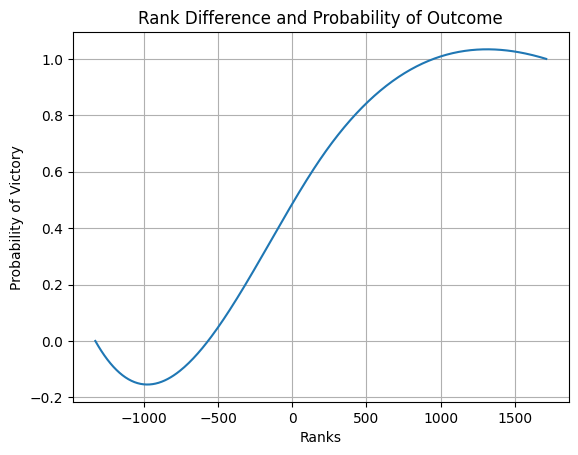

In [9]:
from scipy.interpolate import make_interp_spline

results = [0 if d < 0 else 1 for d in ranks_diff]

bins = np.linspace(min(ranks_diff), max(ranks_diff), 6)

# Calculate probabilities for outcome 1 in each bin
probabilities = []
bin_se = []

for i in range(len(bins)-1):
    mask = (ranks_diff >= bins[i]) & (ranks_diff < bins[i+1])
    if np.sum(mask) > 0:
        prob = np.sum(np.array(results)[mask] == 1) / np.sum(mask)
        se = np.sqrt(prob * (1 - prob) / np.sum(mask))
        probabilities.append(prob)
        bin_se.append(se)
    else:
        probabilities.append(0)
        bin_se.append(0)  # Set a default value for standard error

# Calculate midpoints of bins
bin_midpoints = (bins[:-1] + bins[1:]) / 2

# Use spline interpolation for smooth curve
spline = make_interp_spline(bin_midpoints, probabilities)
x_smooth = np.linspace(min(bin_midpoints), max(bin_midpoints), 300)
y_smooth = spline(x_smooth)

# Interpolate standard errors to match the length of the smooth curve
spline_se = make_interp_spline(bin_midpoints, bin_se)
x_smooth_se = np.linspace(min(bin_midpoints), max(bin_midpoints), 300)
y_smooth_se = spline_se(x_smooth)

# Calculate upper and lower bounds for the shaded polygon using standard errors
upper_bound = y_smooth + y_smooth_se
lower_bound = y_smooth - y_smooth_se

# Plot the smooth curve with standard error polygon
plt.plot(x_smooth, y_smooth, label='Smooth Curve')
plt.fill_between(x_smooth, lower_bound, upper_bound, alpha=0.3, label='Standard Error')
plt.xlabel('Ranks')
plt.ylabel('Probability of Victory')
plt.title('Rank Difference and Probability of Outcome')
plt.grid(True)
plt.show()

In [2031]:
x_smooth_se

array([-1330.5       , -1320.31939799, -1310.13879599, -1299.95819398,
       -1289.77759197, -1279.59698997, -1269.41638796, -1259.23578595,
       -1249.05518395, -1238.87458194, -1228.69397993, -1218.51337793,
       -1208.33277592, -1198.15217391, -1187.97157191, -1177.7909699 ,
       -1167.61036789, -1157.42976589, -1147.24916388, -1137.06856187,
       -1126.88795987, -1116.70735786, -1106.52675585, -1096.34615385,
       -1086.16555184, -1075.98494983, -1065.80434783, -1055.62374582,
       -1045.44314381, -1035.26254181, -1025.0819398 , -1014.90133779,
       -1004.72073579,  -994.54013378,  -984.35953177,  -974.17892977,
        -963.99832776,  -953.81772575,  -943.63712375,  -933.45652174,
        -923.27591973,  -913.09531773,  -902.91471572,  -892.73411371,
        -882.55351171,  -872.3729097 ,  -862.19230769,  -852.01170569,
        -841.83110368,  -831.65050167,  -821.46989967,  -811.28929766,
        -801.10869565,  -790.92809365,  -780.74749164,  -770.56688963,
      

In [1917]:
# compare algorithms
from pandas import read_csv
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# Load dataset
# Split-out validation dataset
array = matchplay_stats_current_only_features.values
X = array[:,1:len(array[0])]
y = array[:,0]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1, shuffle=True)
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# Compare Algorithms
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

LR: 0.640885 (0.020143)
LDA: 0.641210 (0.019251)
KNN: 0.593317 (0.013145)
CART: 0.558421 (0.011018)
NB: 0.636921 (0.017990)


KeyboardInterrupt: 

In [1702]:
# make predictions
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
# Load dataset

# Split-out validation dataset
array = matchplay_stats_current_only_features.values
X = array[:,1:len(array[0])]
y = array[:,0]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)
# Make predictions on validation dataset
model = LogisticRegression(solver='liblinear', multi_class='ovr')
# model = LogisticRegression(solver='liblinear', multi_class='ovr')
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)
# Evaluate predictions
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.6327962577962578
[[1267  633]
 [ 780 1168]]
              precision    recall  f1-score   support

         0.0       0.62      0.67      0.64      1900
         1.0       0.65      0.60      0.62      1948

    accuracy                           0.63      3848
   macro avg       0.63      0.63      0.63      3848
weighted avg       0.63      0.63      0.63      3848



In [703]:
model.coef_

array([[ 0.10538956, -0.10952386, -0.02720576,  0.0090545 ,  0.0045141 ,
         0.24133857,  0.02352859, -0.63629567, -0.60549316,  0.03245773,
        -0.57117326,  0.65180197]])

In [1720]:
validation =  pd.DataFrame(X_validation)
validation['winner'] = Y_validation
validation['predicted_winner'] = predictions
validation['0_better_rank'] = (validation.iloc[:,0] < validation.iloc[:,2])

validation['upset_expected'] = ((validation['0_better_rank'] & validation['predicted_winner'] == 1) |
                                ((validation['0_better_rank'] == False) & (validation['predicted_winner'] == 0)))

validation['upset_occurred'] = ((validation['0_better_rank'] & validation['winner'] == 1) |
                                ((validation['0_better_rank'] == False) & (validation['winner'] == 0)))

validation['correct'] = validation.loc[:,'winner'] == validation.loc[:,'predicted_winner']


# sum(validation.upset_occurred) / len(validation.upset_occurred)
validation

0.6411122661122661

In [1696]:


upsets = validation[(validation[0] > 0) & (validation['winner'] == 1) | (validation[0] < 0) & (validation['winner'] == 0)]
as_expected = validation[(validation[0] < 0) & (validation['winner'] == 1) | (validation[0] > 0) & (validation['winner'] == 0)]
as_expected


,0,1,2,winner,predicted_winner
0,19.0,2220.0,11.0,0.0,1.0
6,82.0,700.0,7.0,0.0,0.0
8,13.0,2725.0,99.0,0.0,1.0
9,172.0,342.0,18.0,0.0,0.0
10,10.0,2615.0,6.0,0.0,1.0
...,...,...,...,...,...
3837,19.0,1940.0,11.0,0.0,1.0
3839,923.0,14.0,148.0,0.0,0.0
3840,55.0,965.0,9.0,0.0,0.0
3844,63.0,816.0,59.0,0.0,0.0


In [421]:
# you need to make this more straghtforward with regard to who won, whether it's an upset, what the sign of the stats mean, etc.

as_expected.loc[:,'predicted_by_model'] = as_expected['winner'] == as_expected['predicted_winner']
upsets.loc[:,'predicted_by_model'] = upsets['winner'] == upsets['predicted_winner']

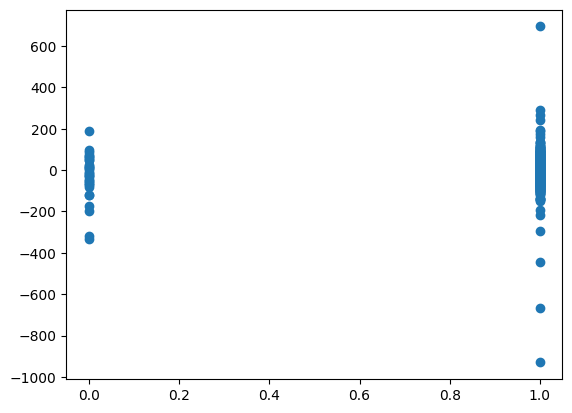

In [422]:
plt.scatter(upsets['predicted_by_model'], upsets[9])
